<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/sai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAI:シロイヌナズナ表皮画像の気孔開度定量
![stomata analysis result](https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/sai.png?raw=true)

*気孔開度自動定量プログラム(StomaAI, SAI)を用いてシロイヌナズナ表皮から気孔開口領域の検出をした結果（本稿のコードによって生成した画像）*

## ライセンス
- Sai et al., New Phytol., 2023 (https://nph.onlinelibrary.wiley.com/doi/10.1111/nph.18765)
    - CC-BY-NC (NCライセンスに準拠するため、図や文章は引用していません)
- SAIレポジトリ (https://github.com/XDynames/SAI-app)
    - GPLv3
- Detectron2 レポジトリ（https://github.com/facebookresearch/detectron2）
    - Apache 2.0
- 本稿プログラムコード
    - **本稿はSAIレポジトリのライセンスを継承するためGPLv3となります。ご注意ください。**

## 解説
筆者ら（開発者ら）は、顕微鏡画像から植物の気孔開度を測るために、次に示す情報を画像から抽出することにしました。
1. 顕微鏡画像中の気孔のbbox座標
2. 気孔開口領域のポリゴン座標
3. 長軸方向における孔辺細胞の両端（開口した際の縁）の点座標

1.と2.を使えば気孔が開口しているか閉鎖しているか、3.を使えば開口開口領域の長軸方向の定義ができる（すなわち、直交方向が開度と関連のあるパラメーターが一意に定まる）。

複数の画像解析のタスクを１度に行うため、筆者らはDetectron2を活用しました。
Detectron2とは、Facebook AIが開発した、detection/segmentation/keypoint detectionなどあらゆるタスクに対応したライブラリです。

<img width=10% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/56452f37c1b15b0d3c4baf1c2f6f88b80d82c95ce03734b7a69edbee69865e65.png" alt="picture 1">
<img width=20% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/959e8c37e5aaf7f4848ea9d538d7c0ffba75948506390d4bd7f7da6507b0bd79.png" alt="picture 0">
<img width=20% src="https://cdn.jsdelivr.net/gh/phytometrics/plant_phenotyping_python@main/assets/778a1f100e2b3d19a1a9dcbd6b38ad955dd449539439697505d4dd2c1c396500.png" alt="picture 2">


*左から順番にInstance Segmentation, Object Detection, Human Keypoint Detectionを適用した結果。
Detectron2のチュートリアルコード（https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5） より*

Detectron2自体の解説は他章で行います。

今回はDetectron2を用いて訓練したモデルをColaboratoryで使用し、気孔開度定量を行うコードを紹介します。

# 実行コード

In [1]:
!git clone https://github.com/XDynames/SAI-app.git
!mv SAI-app SAI_app

Cloning into 'SAI-app'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 189 (delta 49), reused 32 (delta 31), pack-reused 111
Receiving objects: 100% (189/189), 962.54 KiB | 2.92 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [2]:
#model weights, shall be moved to figshare?
IMAGES = [
    "https://cloudstor.aarnet.edu.au/plus/s/AMYCHSdmOgUFbKr",
    "https://cloudstor.aarnet.edu.au/plus/s/RJt9ny7k2PTNrgc",
    "https://cloudstor.aarnet.edu.au/plus/s/nTO1fFwwLDCeIUG",
    "https://cloudstor.aarnet.edu.au/plus/s/2ZC9oxmyGr6s483"
          ]


In [ ]:
!wget -O arabidipsis_weights.pth https://cloudstor.aarnet.edu.au/plus/s/iLB4PwuKqjbdSWg/download
!wget -O arabidosis_config.yaml https://cloudstor.aarnet.edu.au/plus/s/wrWnwgdVDNaCFRC/download
!wget -O Base-RCNN-FPN.yaml https://cloudstor.aarnet.edu.au/plus/s/WWGw6Pjt7czIjDc/download

In [ ]:
import os
!mkdir images
for i, image in enumerate(IMAGES):
    path = os.path.join(image,"download")
    !wget -O {"images/"+str(i).zfill(3)+".jpg"} {path}

In [ ]:
!pip3 install git+https://github.com/facebookresearch/detectron2.git

In [ ]:
!pip install streamlit  # 使わないけれどもimport error対策としてインストールする
!pip install shapely
!pip install mask_to_polygons


In [2]:
# !cp /content/SAI_app/inference/post_processing.py /content/SAI_app/inference/post_processing2.py
# !sed -i '7c\from SAI_app.tools.constants import (' /content/SAI_app/inference/post_processing2.py

In [1]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
import pandas as pd

import detectron2
from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.visualizer import ColorMode, Visualizer

%cd SAI-app
!sed -i '18s/.*/"camera_calibration": 10.25131,/' /content/SAI-app/tools/state.py

from app import utils
from app.inference import predictions_to_list_of_dictionaries
from app.example_images import draw_bounding_boxes, draw_measurements

from inference.modeling.stoma_head import KRCNNConvHead, KPROIHeads
from inference.post_processing import get_indices_of_valid_predictions

/content/SAI-app


2023-10-12 06:57:10.609 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-12 06:57:10.612 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [2]:
def get_config():
    # BASEconfigにナズナ用を上書きしているのでこんな書き方になる
    cfg = detectron2.config.get_cfg()
    cfg.MODEL.ROI_KEYPOINT_HEAD.POOLER_RESOLUTION = (14, 14)
    cfg.merge_from_file("/content/arabidosis_config.yaml")
    cfg.MODEL.WEIGHTS = "/content/arabidipsis_weights.pth"
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.6
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = (0.6)
    if torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cuda"
    cfg.freeze()
    return cfg

In [3]:
config = get_config()
metadata = MetadataCatalog.get(config.DATASETS.TEST[0])

In [4]:
predictor = DefaultPredictor(config)

  pixel_mean
  pixel_std


In [5]:
path = "/content/images/000.jpg"
image = cv2.imread(path)[...,::-1]

In [6]:
## demo.run_on_image
with torch.no_grad():
    predictions = predictor(image)
## _post_process_predictions
instances = predictions["instances"].to(torch.device("cpu"))
valid_indices = get_indices_of_valid_predictions(instances)
predictions["instances"] = instances
## return predictions, valid_indices

## run_on_image
valid_indices = get_indices_of_valid_predictions(instances)
# return  predictions["instances"], time_elapsed, valid_indices
predictions, valid_indices = predictions_to_list_of_dictionaries(
    predictions["instances"], valid_indices
)
valid_predictions = utils.select_predictions(predictions, valid_indices)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


最終的な結果を見てみましょう。

In [18]:
[{"stoma_id": d["stoma_id"], "length": d["length"], "width": d["width"]} for d in valid_predictions]

[{'stoma_id': 0, 'length': 70.97708254483491, 'width': 23.021361949580214},
 {'stoma_id': 1, 'length': 58.36308764964376, 'width': 20.202607263338216},
 {'stoma_id': 2, 'length': 106.62630456560508, 'width': 15.255813323979906},
 {'stoma_id': 3, 'length': 86.38223120159238, 'width': 18.358726642311513}]

描画します

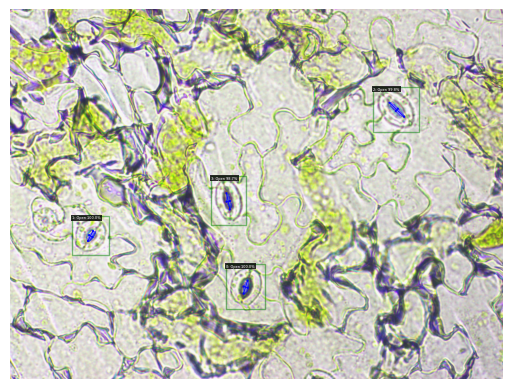

In [8]:
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(image)
# Draw onto axis
# utils.is_mode_view_example()はui側で制御されているので、選択できない？通常はcamera_calibrationから値をとってくる→arabidopsis  10.25131
# sedでstate.pyをいじっておく、あらかじめ。
draw_measurements(ax, valid_predictions)
draw_bounding_boxes(ax, predictions)


## おまけ
SAIのレポジトリはブラウザで解析を可能とするstreamlitを活用しています。

レポジトリに従って環境構築すれば自身のPCでGUIベースのプログラムを走らせることが可能です。

また、筆者らによるオンラインサービス（https://sai.aiml.team/）　も提供されているので興味のある方は確認してみてください。

<img width=25% src="https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/sai_streamlit.png?raw=true">

https://sai.aiml.team/ のスクリーンショット。Arabidopsisの他に、barleyのモデルも提供されています。


本稿のコードはレポジトリから解析部分のみを抜粋し、Colaboratoryで動作するようにカスタマイズしたものです。